# Importing libraries

In [1]:
from tqdm import tqdm
import os
import cv2
import numpy as np
from skimage import exposure
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Defining the path to the dataset

In [3]:
dataset_path = 'C:/Users/Ahmed/Sections/Tomato-Detection/data'

# Load class names from data.yaml

In [4]:
class_names = ["0", "1", "Fresh Tomato", "Rotten Tomato", "object"]

# Define a function to read images and labels from the dataset

In [5]:
def read_anotation(file_path):
    def anot_fun(row):
        row = row.split()
        row = {'class_label': int(row[0]),
               'x_min': float(row[1]),
               'y_min': float(row[2]),
               'width': float(row[3]),
               'height': float(row[4])
              }
        return row
    
    with open(file_path) as f:
        data = f.read().strip()
        data = data.split('\n')
        data = list(filter(lambda x: len(x) >= 5, data))
        data = list(map(anot_fun, data))
        return data
def load_data(folder):
    data = list(filter(lambda x: x.endswith('.jpg') or x.endswith('.png'), os.listdir(os.path.join(folder, 'images'))))
    data_size = len(data)
    def pat2data(filename):
        img_path = os.path.join(folder, 'images', filename)
        label_path = os.path.join(folder, 'labels', filename.replace('.jpg', '.txt'))
        img = cv2.imread(img_path)
        anotation = read_anotation(label_path)

        return img, anotation
            
    
    data = list(map(pat2data, tqdm(data)))
    images = [i[0] for i in data]
    labels = [i[1] for i in data]

    return images, labels

# Loading dataset

In [6]:
data = load_data(dataset_path);
images, labels = data

100%|██████████| 1000/1000 [00:10<00:00, 91.40it/s]


# Define a function to preprocess the images using HOG

In [7]:
def preprocess_image(image):
    # Convert image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply HOG feature extraction
    features = hog(gray_img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False,)

    return features

# Preprocess dataset images using HOG

In [8]:
images = list(map(preprocess_image, tqdm(images)))

100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


# Flatten the HOG features and adjust labels for multiple objects in an image

In [9]:
def split_objects(x, y):
    new_x, new_y = [], []
    for img, objs in zip(x, y):
        for o in objs:
            new_x.append(img)
            new_y.append(o)
    return new_x, new_y

# Flatten the dataset

In [10]:
new_images, new_labels = split_objects(images, labels)
new_images = np.array(new_images)

In [11]:
label_values = [label['class_label'] for label in new_labels]

label_encoder = LabelEncoder()
new_labels_encoded = label_encoder.fit_transform(label_values)

# Splitting the dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(new_images, new_labels_encoded, test_size=0.3, random_state=42)

# Training the logistic regression model

In [17]:
logreg_model = LogisticRegression(solver='saga', max_iter=1000)
logreg_model.fit(new_images, new_labels_encoded)

LogisticRegression(max_iter=1000, solver='saga')

# Evaluation the model on the test set

In [18]:
test_predictions = logreg_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.68


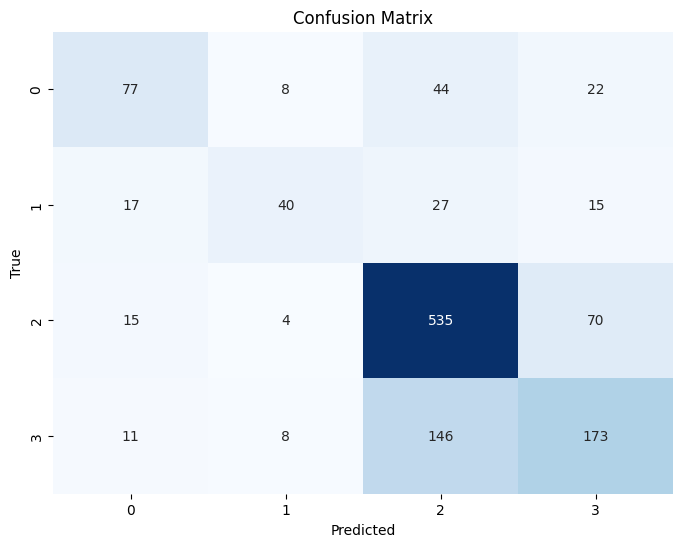

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


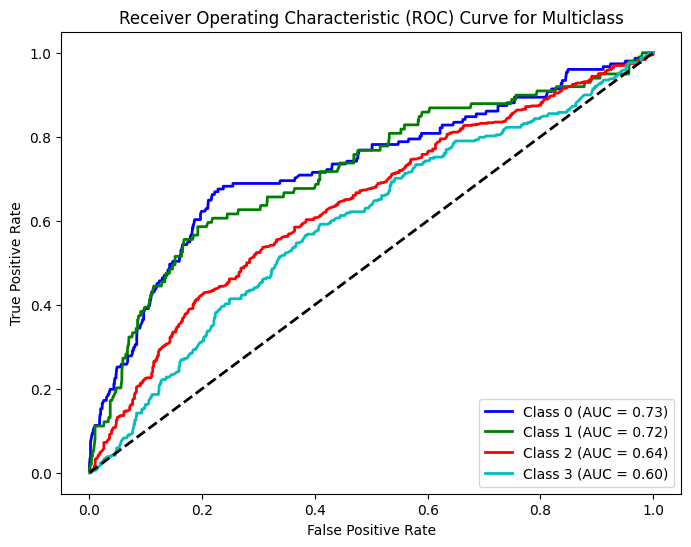

In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))  

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

classifier = OneVsRestClassifier(logreg_model) 
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()


In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [26]:
cluster_centers = kmeans.cluster_centers_

labels = kmeans.labels_

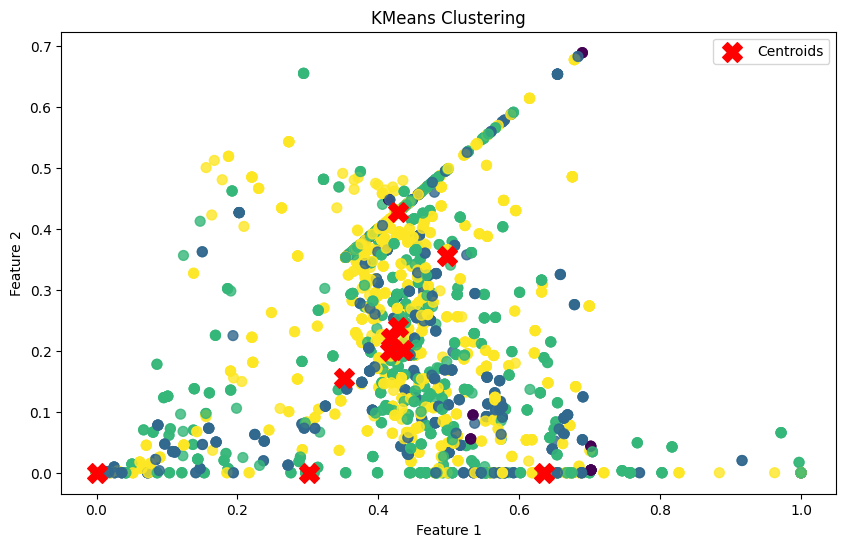

In [30]:
plt.figure(figsize=(10, 6))

plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()